In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from skimage.transform import resize

In [2]:
import datajoint as dj

In [3]:
schema = dj.schema('trasfer')

Connecting root@localhost:3306


In [4]:
@schema
class Source(dj.Lookup):
    definition = """
    name : char(12)
    ---
    image_url : varchar(255)
    """
    
    contents = (
        ('mona', 'https://upload.wikimedia.org/wikipedia/commons/5/55/Mona_Lisa_headcrop.jpg'),
        ('starry', 'https://upload.wikimedia.org/wikipedia/commons/f/f2/VangoghStarry-night2.jpg'),
        ('eye', 'https://upload.wikimedia.org/wikipedia/commons/4/42/GreenEye3.jpg'),
        ('sunflower', 'https://upload.wikimedia.org/wikipedia/commons/e/e5/Sonnenblume_Helianthus_1.JPG')
    )

In [5]:
import requests
import os

@schema
class Image(dj.Imported):
    definition = """
    -> Source
    ---
    image : longblob
    """
    
    def make(self, key):
        url = (Source & key).fetch1('image_url')
        tempfile = 'image.tmp'
        with open(tempfile, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, image=plt.imread(tempfile)))
        os.unlink(tempfile)

In [6]:
Image.populate(display_progress=True)

Image: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


In [7]:
Image() * Source

name,image,image_url
eye,=BLOB=,https://upload.wikimedia.org/wikipedia/commons/4/42/GreenEye3.jpg
mona,=BLOB=,https://upload.wikimedia.org/wikipedia/commons/5/55/Mona_Lisa_headcrop.jpg
starry,=BLOB=,https://upload.wikimedia.org/wikipedia/commons/f/f2/VangoghStarry-night2.jpg
sunflower,=BLOB=,https://upload.wikimedia.org/wikipedia/commons/e/e5/Sonnenblume_Helianthus_1.JPG


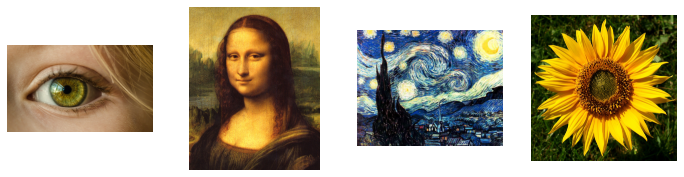

In [8]:
fig, ax = plt.subplots(1, len(Image()), figsize=(len(Image())*3,3))
for a, img in zip(ax, Image.fetch('image')):
    a.imshow(img)
    a.axis(False)

In [10]:
dj.Diagram()

TypeError: __init__() missing 1 required positional argument: 'source'

In [11]:
@schema
class Crop(dj.Computed):
    definition = """
    -> Image
    ---
    cropped_image : longblob
    """
    
    def make(self, key):
        img = (Image & key).fetch1('image')
        sz = min((img.shape[:2]))
        sz1 = (img.shape[0] - sz)//2
        sz2 = (img.shape[1] - sz)//2
        img = imutils.resize(img[sz1:sz1+sz, sz2:sz2+sz], width=600, height =600)
        #img = resize(img[sz1:sz1+sz, sz2:sz2+sz], (512,512))
        self.insert1(dict(key, cropped_image=img))

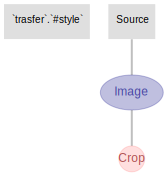

In [12]:
dj.Di(schema)

In [14]:
import numpy as np
import cv2
import imutils

In [15]:
Crop.populate(display_progress=True)

Crop: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


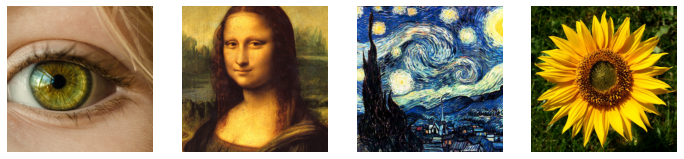

In [16]:
fig, ax = plt.subplots(1, len(Crop()), figsize=(len(Crop())*3,3))
for a, img in zip(ax, Crop.fetch('cropped_image')):
    a.imshow(img)
    a.axis(False)

In [17]:

@schema
class Style(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = (['udnie'], ['la_muse'], ['starry_night'], ['mosaic'])

In [18]:
image = Crop.fetch('cropped_image', limit=1)[0]

In [24]:
    net = cv2.dnn.readNetFromTorch('/home/ubuntu/StyleTransfer/notebooks/models/udnie.t7')    
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # construct a blob from the image, set the input, and then perform a
    # forward pass of the network
    blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
                                 (103.939, 116.779, 123.680), swapRB=False, crop=False)
    net.setInput(blob)
    output = net.forward()

    # reshape the output tensor, add back in the mean subtraction, and
    # then swap the channel ordering
    output = output.reshape((3, output.shape[2], output.shape[3]))
    output[0] += 103.939
    output[1] += 116.779
    output[2] += 123.680
    output = output.transpose(1, 2, 0)
    output = np.clip(output, 0, 255)
    output= output.astype('uint8')

error: OpenCV(4.5.1) /tmp/pip-req-build-jr1ur_cf/opencv/modules/dnn/src/torch/THDiskFile.cpp:496: error: (-2:Unspecified error) cannot open </home/ubuntu/StyleTransfer/notebooks/models/udnie.t7> in mode r  in function 'THDiskFile_new'


In [20]:
image.shape

(600, 600, 3)

In [21]:
ls models

la_muse.t7  mosaic.t7  starry_night.t7  udnie.t7


In [22]:
plt.imshow(output)

NameError: name 'output' is not defined